# Utilities

In [78]:
import pandas as pd
import numpy as np
import re
import math
import pickle
import xgboost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from pprint import pprint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [79]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} points.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

---
# Read datasets

In [81]:
# Read forwards and defensemen
# Merge the two
nhl_def = pd.read_csv('nhl_def.csv', sep=';')
nhl_att = pd.read_csv('nhl_att.csv', sep=';')
nhl_players = pd.concat([nhl_att, nhl_def])

# Rename Index
nhl_players = nhl_players.rename(columns={'Unnamed: 0': 'Player'}).set_index('Player')

# Remve NaN indexes
nhl_players.drop('NANNAN', inplace=True)

# Remove space in team names
nhl_players['Team'] = nhl_players.apply(lambda player: re.sub(r'\s+', '', player['Team']), axis=1)

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [83]:
nhl_players.head(10)

,$/PTS_13,$/PTS_14,$/PTS_15,$/PTS_16,$/PTS_17,$/PTS_18,A_13,A_14,A_15,A_16,A_17,A_18,Age,Cap Cost_13,Cap Cost_14,Cap Cost_15,Cap Hit_16,Cap Hit_17,Cap Hit_18,Cap_Hit,END,First_Name,GC_18,GP_13,GP_14,GP_15,GP_16,GP_17,GP_18,GP_mean,GP_var,GS/G_17,GS/G_18,G_13,G_14,G_15,G_16,G_17,G_18,Last_Name,OPS_17,OPS_18,OWAR_18,PAX_18,PDO_17,PDO_18,PPTOI/GP_17,PPTOI/GP_18,PTS/G_13,PTS/G_14,PTS/G_15,PTS/G_16,PTS/G_17,PTS/G_18,PTS/G_mean,PTS/G_var,PTS_13,PTS_14,PTS_15,PTS_16,PTS_17,PTS_18,PTS_mean,PTS_var,Position,SCF_17,SCF_18,Score,Sh%_13,Sh%_14,Sh%_15,Sh%_16,Sh%_17,Sh%_18,Star,TOI/G_13,TOI/G_14,TOI/G_15,TOI/G_16,TOI/G_17,TOI/G_18,Team,ZS%_18,iCF_17,iCF_18,iFF_17,iFF_18,iSF_13,iSF_14,iSF_15,iSF_16,iSF_17,iSF_18
Player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OVECHKINALEX,99705.177700,114850.267984,116317.073171,129423.222260,138238.579710,109637.494253,24.0,28.0,28.0,21.0,36.0,38.0,33.0,9538462.0,9538462.0,9538000.0,9538000.0,9538462.0,9538462.0,9538462.0,21.0,Alex,35.6,48.0,78.0,81.0,79.0,82.0,82.0,80.400000,2.640000,NaN,1.12,32.0,51.0,53.0,50.0,33.0,49.0,Ovechkin,NaN,9.3,5.14,-5.1,1025,-0.025,3.64,4.21,1.166667,1.012821,1.000000,0.898734,0.841463,1.060976,0.996777,0.011164,56.0,79.0,81.0,71.0,69.0,87.0,77.400000,43.840000,LW,NaN,1005.0,10.382087,0.145,0.132,0.134,0.126,0.113,0.123,17.1676,20.9,20.5,20.3,20.3,18.37,20.14,WSH,0.686,624.0,705.0,455.0,526.0,220.0,386.0,395.0,398.0,313.0,355.0
MCDAVIDCONNOR,NaN,NaN,NaN,10575.457317,9250.000000,8564.814815,NaN,NaN,NaN,32.0,70.0,67.0,22.0,NaN,NaN,NaN,925000.0,925000.0,925000.0,12500000.0,NaN,Connor,40.6,NaN,NaN,NaN,45.0,82.0,82.0,69.666667,304.222222,NaN,1.32,NaN,NaN,NaN,16.0,30.0,41.0,McDavid,NaN,10.5,7.86,12.4,1032,-0.004,2.87,2.97,NaN,NaN,NaN,1.066667,1.219512,1.317073,1.201084,0.010620,NaN,NaN,NaN,48.0,100.0,108.0,85.333333,707.555556,C,NaN,1184.0,9.695512,NaN,NaN,NaN,0.152,0.124,0.104,18.1365,NaN,NaN,NaN,18.9,21.13,21.55,EDM,0.611,421.0,434.0,329.0,357.0,NaN,NaN,NaN,105.0,252.0,275.0
CROSBYSIDNEY,68205.574913,81613.508443,97256.097561,99856.527977,89408.057002,97752.808989,41.0,68.0,56.0,49.0,45.0,60.0,31.0,8700000.0,8700000.0,8700000.0,8700000.0,8700000.0,8700000.0,8700000.0,25.0,Sidney,32.1,36.0,80.0,77.0,80.0,75.0,82.0,78.800000,6.160000,NaN,1.14,15.0,36.0,28.0,36.0,44.0,29.0,Crosby,NaN,7.3,3.09,-18.7,1031,-0.008,3.47,3.65,1.555556,1.300000,1.090909,1.062500,1.186667,1.085366,1.213500,0.029909,56.0,104.0,84.0,85.0,89.0,89.0,90.200000,51.760000,C,NaN,1215.0,9.428396,0.121,0.139,0.118,0.145,0.114,0.108,12.6759,21.1,22.0,20.0,20.5,19.88,20.69,PIT,0.663,411.0,412.0,325.0,341.0,124.0,259.0,237.0,248.0,255.0,247.0
KUCHEROVNIKITA,NaN,31501.818428,13676.923077,10130.081301,50607.368436,46504.068293,NaN,9.0,36.0,36.0,45.0,61.0,25.0,NaN,894167.0,889000.0,712000.0,4766667.0,4766667.0,4766667.0,19.0,Nikita,37.4,NaN,52.0,82.0,77.0,74.0,80.0,73.000000,117.600000,NaN,1.27,NaN,9.0,29.0,30.0,40.0,39.0,Kucherov,NaN,9.8,5.29,34.3,1032,-0.035,3.20,3.51,NaN,0.346154,0.792683,0.857143,1.148649,1.250000,0.878926,0.100441,NaN,18.0,65.0,66.0,85.0,100.0,66.800000,763.760000,RW,NaN,1036.0,9.178601,NaN,0.088,0.152,0.144,0.120,0.119,14.4986,NaN,13.1,15.0,18.2,19.43,19.82,TBL,0.709,464.0,546.0,348.0,422.0,NaN,102.0,191.0,209.0,246.0,279.0
MALKINEVGENI,99667.405765,88414.634146,114198.606272,113856.181665,99762.872629,92210.054754,24.0,49.0,42.0,31.0,39.0,56.0,32.0,8700000.0,8700000.0,9500000.0,9500000.0,9500000.0,9500000.0,9500000.0,22.0,Evgeni,37.5,31.0,60.0,69.0,57.0,62.0,78.0,65.200000,56.560000,NaN,1.16,9.0,23.0,28.0,27.0,33.0,42.0,Malkin,NaN,10.2,3.21,6.1,1052,-0.031,3.53,3.67,1.064516,1.200000,1.014493,1.017544,1.161290,1.256410,1.119042,0.008569,33.0,72.0,70.0,58.0,72.0,98.0,74.000000,171.200000,C,NaN,1003.0,9.148459,0.091,0.120,0.132,0.167,0.122,0.120,15.3639,19.7,20.1,19.0,19.4,18.62,18.99,PIT,0.740,315.0,379.0,250.0,306.0,99.0,191.0,212.0,162.0,193.0,239.0
MACKINNONNATHAN,NaN,59920.634921,77535.301669,15619.136961,118867.924528,58612.019110,NaN,39.0,24.0,3

In [13]:
nhl_players.columns

Index(['$/PTS_13', '$/PTS_14', '$/PTS_15', '$/PTS_16', '$/PTS_17', '$/PTS_18',
       'A_13', 'A_14', 'A_15', 'A_16', 'A_17', 'A_18', 'Age', 'Cap Cost_13',
       'Cap Cost_14', 'Cap Cost_15', 'Cap Hit_16', 'Cap Hit_17', 'Cap Hit_18',
       'Cap_Hit', 'END', 'First_Name', 'GC_18', 'GP_13', 'GP_14', 'GP_15',
       'GP_16', 'GP_17', 'GP_18', 'GP_mean', 'GP_var', 'GS/G_17', 'GS/G_18',
       'G_13', 'G_14', 'G_15', 'G_16', 'G_17', 'G_18', 'Last_Name', 'OPS_17',
       'OPS_18', 'OWAR_18', 'PAX_18', 'PDO_17', 'PDO_18', 'PPTOI/GP_17',
       'PPTOI/GP_18', 'PTS/G_13', 'PTS/G_14', 'PTS/G_15', 'PTS/G_16',
       'PTS/G_17', 'PTS/G_18', 'PTS/G_mean', 'PTS/G_var', 'PTS_13', 'PTS_14',
       'PTS_15', 'PTS_16', 'PTS_17', 'PTS_18', 'PTS_mean', 'PTS_var',
       'Position', 'SCF_17', 'SCF_18', 'Score', 'Sh%_13', 'Sh%_14', 'Sh%_15',
       'Sh%_16', 'Sh%_17', 'Sh%_18', 'Star', 'TOI/G_13', 'TOI/G_14',
       'TOI/G_15', 'TOI/G_16', 'TOI/G_17', 'TOI/G_18', 'Team', 'ZS%_18',
       'iCF_17', 'iCF_18

---
# Preprocessing

## Convert categorical features

### Team

In [14]:
nhl_players = pd.concat([nhl_players, pd.get_dummies(nhl_players['Team'])], axis=1)
nhl_players = nhl_players.drop('Team', axis=1)

### Position

In [15]:
nhl_players = pd.concat([nhl_players, pd.get_dummies(nhl_players['Position'])], axis=1)
nhl_players = nhl_players.drop('Position', axis=1)

## Remove unecessary features

In [16]:
nhl_players = nhl_players.drop(['Last_Name', 'First_Name', 'G_13', 'G_14',
       'G_15', 'G_16', 'G_17', 'G_18', 'A_13', 'A_14', 'A_15', 'A_16', 'A_17',
       'A_18', 'PTS/G_18', '$/PTS_13', '$/PTS_14', '$/PTS_15', '$/PTS_16', '$/PTS_17', '$/PTS_18', 'Cap Cost_13', 'Cap Cost_14', 'Cap Cost_15', 'Cap Hit_16',
       'Cap Hit_17', 'Cap Hit_18', 'Cap_Hit', 'END', 'Star', 'GC_18', 'GS/G_18', 'OPS_18', 'OWAR_18', 'PAX_18', 'PDO_18',
       'PPTOI/GP_18', 'SCF_18', 'ZS%_18', 'iCF_18', 'iFF_18', 'iSF_18', 'GP_18', 'Sh%_18', 'Score', 'TOI/G_18'], axis=1)

## NaN correction

In [17]:
nhl_players = nhl_players.apply(pd.to_numeric)
nhl_players = nhl_players.fillna(nhl_players.mean())

---
# Explore Data

In [18]:
nhl_players.describe()

,Age,GP_13,GP_14,GP_15,GP_16,GP_17,GP_mean,GP_var,GS/G_17,OPS_17,...,WPG,WSH,C,C/RW,D,LW,LW/C,LW/RW,RW,RW/C
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,...,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,27.088864,35.113158,60.187082,59.011472,56.585174,55.569863,48.883521,233.778580,0.325242,1.040726,...,0.031496,0.030371,0.265467,0.001125,0.344207,0.193476,0.030371,0.001125,0.152981,0.011249
std,4.333244,9.935611,17.455487,19.744766,22.939548,24.719574,25.575564,311.452926,0.124480,0.826135,...,0.174752,0.171703,0.441830,0.033539,0.475376,0.395245,0.171703,0.033539,0.360172,0.105521
min,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-0.380000,-1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,35.113158,60.187082,59.011472,56.000000,46.000000,27.000000,11.200000,0.325242,1.040726,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,35.113158,60.187082,59.011472,56.585174,58.000000,56.000000,83.760000,0.325242,1.040726,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,38.000000,71.000000,74.000000,76.000000,78.000000,71.600000,358.222222,0.325242,1.040726,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,46.000000,48.000000,82.000000,84.000000,84.000000,82.000000,82.400000,1600.000000,1.180000,8.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
nhl_players.head(10)

,Age,GP_13,GP_14,GP_15,GP_16,GP_17,GP_mean,GP_var,GS/G_17,OPS_17,...,WPG,WSH,C,C/RW,D,LW,LW/C,LW/RW,RW,RW/C
Player,,,,,,,,,,,,,,,,,,,,,
OVECHKINALEX,33.0,48.000000,78.000000,81.000000,79.0,82.0,80.400000,2.640000,0.325242,1.040726,...,0,1,0,0,0,1,0,0,0,0
MCDAVIDCONNOR,22.0,35.113158,60.187082,59.011472,45.0,82.0,69.666667,304.222222,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0
CROSBYSIDNEY,31.0,36.000000,80.000000,77.000000,80.0,75.0,78.800000,6.160000,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0
KUCHEROVNIKITA,25.0,35.113158,52.000000,82.000000,77.0,74.0,73.000000,117.600000,0.325242,1.040726,...,0,0,0,0,0,0,0,0,1,0
MALKINEVGENI,32.0,31.000000,60.000000,69.000000,57.0,62.0,65.200000,56.560000,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0
MACKINNONNATHAN,23.0,35.113158,82.000000,64.000000,72.0,82.0,74.800000,45.760000,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0
KESSELPHIL,31.0,48.000000,82.000000,82.000000,82.0,82.0,82.000000,0.000000,0.325242,1.040726,...,0,0,0,0,0,0,0,0,1,0
SEGUINTYLER,27.0,48.000000,80.000000,71.000000,72.0,82.0,77.400000,23.840000,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0
GIROUXCLAUDE,31.0,48.000000,82.000000,81.000000,78.0,82.0,81.000000,2.400000,0.325242,1.040726,...,0,0,1,0,0,0,0,0,0,0


In [73]:
nhl_players.columns

Index(['Age', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_mean', 'GP_var',
       'GS/G_17', 'OPS_17', 'PDO_17', 'PPTOI/GP_17', 'PTS/G_13', 'PTS/G_14',
       'PTS/G_15', 'PTS/G_16', 'PTS/G_17', 'PTS/G_mean', 'PTS/G_var', 'PTS_13',
       'PTS_14', 'PTS_15', 'PTS_16', 'PTS_17', 'PTS_18', 'PTS_mean', 'PTS_var',
       'SCF_17', 'Sh%_13', 'Sh%_14', 'Sh%_15', 'Sh%_16', 'Sh%_17', 'TOI/G_13',
       'TOI/G_14', 'TOI/G_15', 'TOI/G_16', 'TOI/G_17', 'iCF_17', 'iFF_17',
       'iSF_13', 'iSF_14', 'iSF_15', 'iSF_16', 'iSF_17', 'ANA', 'ARI', 'BOS',
       'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL', 'DAL', 'DET', 'EDM', 'FLA',
       'LAK', 'MIN', 'MTL', 'NJD', 'NSH', 'NYI', 'NYR', 'OTT', 'PHI', 'PIT',
       'SJS', 'STL', 'TBL', 'TOR', 'VAN', 'VGK', 'WPG', 'WSH', 'C', 'C/RW',
       'D', 'LW', 'LW/C', 'LW/RW', 'RW', 'RW/C'],
      dtype='object')

---
# Build Training and Test Sets

In [74]:
# Labels are the values we want to predict
labels = nhl_players['PTS_18']

# Remove the labels from the features
# axis 1 refers to the columns
features = nhl_players.drop('PTS_18', axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [54]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [55]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (666, 83)
Training Labels Shape: (666,)
Testing Features Shape: (223, 83)
Testing Labels Shape: (223,)


---
# Train/Test Model - RF

## Standard

In [63]:
%%time
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

CPU times: user 92.3 ms, sys: 1.98 ms, total: 94.3 ms
Wall time: 93.5 ms


In [64]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

Mean Absolute Error: 5.59 points.
Mean Squared Error: 76.42 points.
Explained Variance Score: 0.85
R2 Score: 0.85


In [65]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PTS_mean             Importance: 0.74
Variable: PTS/G_mean           Importance: 0.07
Variable: PTS_var              Importance: 0.07
Variable: Age                  Importance: 0.03
Variable: GP_mean              Importance: 0.01
Variable: GP_var               Importance: 0.01
Variable: PTS/G_var            Importance: 0.01
Variable: GP_13                Importance: 0.0
Variable: GP_14                Importance: 0.0
Variable: GP_15                Importance: 0.0
Variable: GP_16                Importance: 0.0
Variable: GP_17                Importance: 0.0
Variable: GS/G_17              Importance: 0.0
Variable: OPS_17               Importance: 0.0
Variable: PDO_17               Importance: 0.0
Variable: PPTOI/GP_17          Importance: 0.0
Variable: PTS/G_13             Importance: 0.0
Variable: PTS/G_14             Importance: 0.0
Variable: PTS/G_15             Importance: 0.0
Variable: PTS/G_16             Importance: 0.0
Variable: PTS/G_17             Importance: 0.0
Variab

In [70]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_18
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,PTS_18,Prediction,Difference
count,223.000000,223.000000,223.000000
mean,21.964126,22.602242,0.638117
std,22.276893,20.851805,8.738026
min,0.000000,0.000000,-31.900000
10%,1.000000,1.000000,-9.420000
25%,4.000000,5.850000,-2.400000
50%,15.000000,15.600000,0.200000
75%,33.500000,34.100000,4.300000
90%,59.800000,53.900000,9.260000
max,97.000000,93.900000,44.500000


In [71]:
results.sort_values('Difference')

,PTS_18,Prediction,Difference
Player,,,
GOURDEYANNI,64.0,32.1,-31.9
MACKINNONNATHAN,97.0,67.3,-29.7
BAILEYJOSH,71.0,48.5,-22.5
DUMBAMATT,50.0,29.2,-20.8
BARKOVALEKSANDER,78.0,57.9,-20.1
HAULAERIK,55.0,35.8,-19.2
RYANDEREK,38.0,18.8,-19.2
KUZNETSOVEVGENY,83.0,65.6,-17.4
SOBOTKAVLADIMIR,31.0,13.6,-17.4


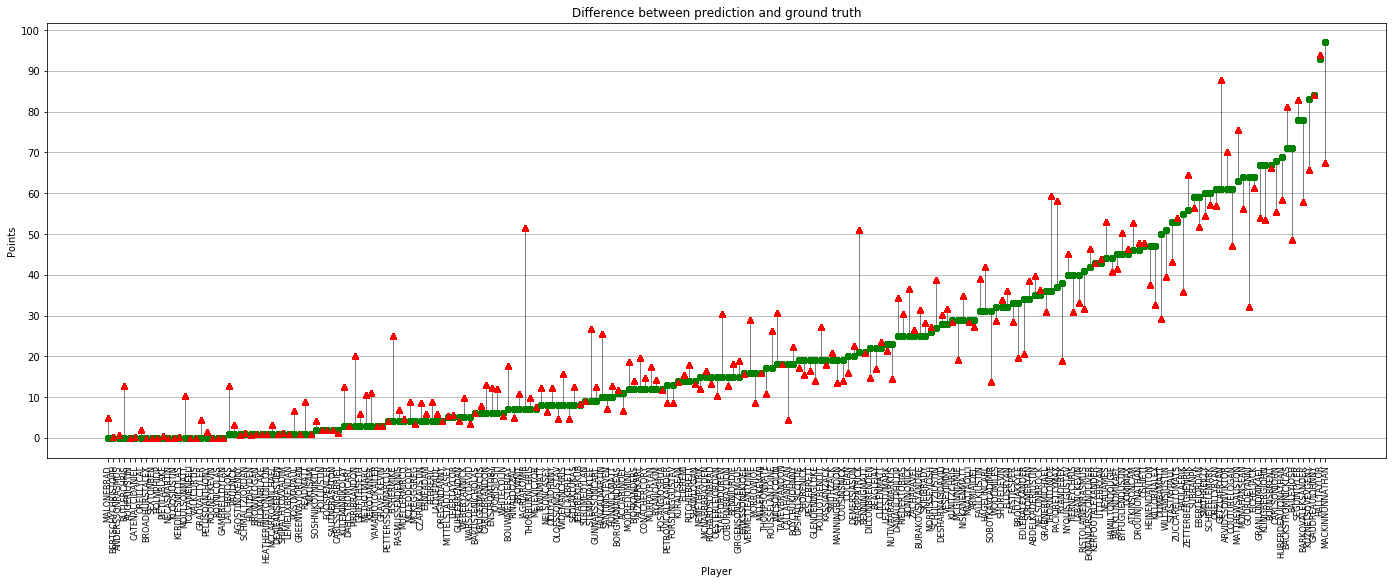

In [61]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## Hyperparameter Tuning

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# pprint(random_grid)

In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(train_features, train_labels)

In [ ]:
# # Best parameters
# rf_random.best_params_

In [ ]:
# # Random performance
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, test_features, test_labels)

In [ ]:
# Random performance
best_random_file = 'random_forest_best.pickle'
best_random = pickle.load(open(best_random_file, 'rb'))
random_accuracy = evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 5.2840 points.
Accuracy = nan%.


/home/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
# Use the forest's predict method on the test data
predictions = best_random.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

Mean Absolute Error: 5.28 points.
Mean Squared Error: 70.79 points.
Explained Variance Score: 0.86
R2 Score: 0.86


In [ ]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PTS_mean             Importance: 0.75
Variable: PTS/G_mean           Importance: 0.07
Variable: PTS_var              Importance: 0.06
Variable: Age                  Importance: 0.02
Variable: GP_var               Importance: 0.01
Variable: PTS/G_var            Importance: 0.01
Variable: PTS_14               Importance: 0.01
Variable: GP_13                Importance: 0.0
Variable: GP_14                Importance: 0.0
Variable: GP_15                Importance: 0.0
Variable: GP_16                Importance: 0.0
Variable: GP_17                Importance: 0.0
Variable: GP_mean              Importance: 0.0
Variable: GS/G_17              Importance: 0.0
Variable: OPS_17               Importance: 0.0
Variable: PDO_17               Importance: 0.0
Variable: PPTOI/GP_17          Importance: 0.0
Variable: PTS/G_13             Importance: 0.0
Variable: PTS/G_14             Importance: 0.0
Variable: PTS/G_15             Importance: 0.0
Variable: PTS/G_16             Importance: 0.0
Variab

In [ ]:
# # Save best estimator
# filename = 'random_forest_best.pickle'
# pickle.dump(best_random, open(filename, 'wb'))

In [ ]:
# Compare base and tuned estimator
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of nan%.


---
# Visualize Results

In [ ]:
# Use the forest's predict method on the test data
best_predictions = best_random.predict(test_features)

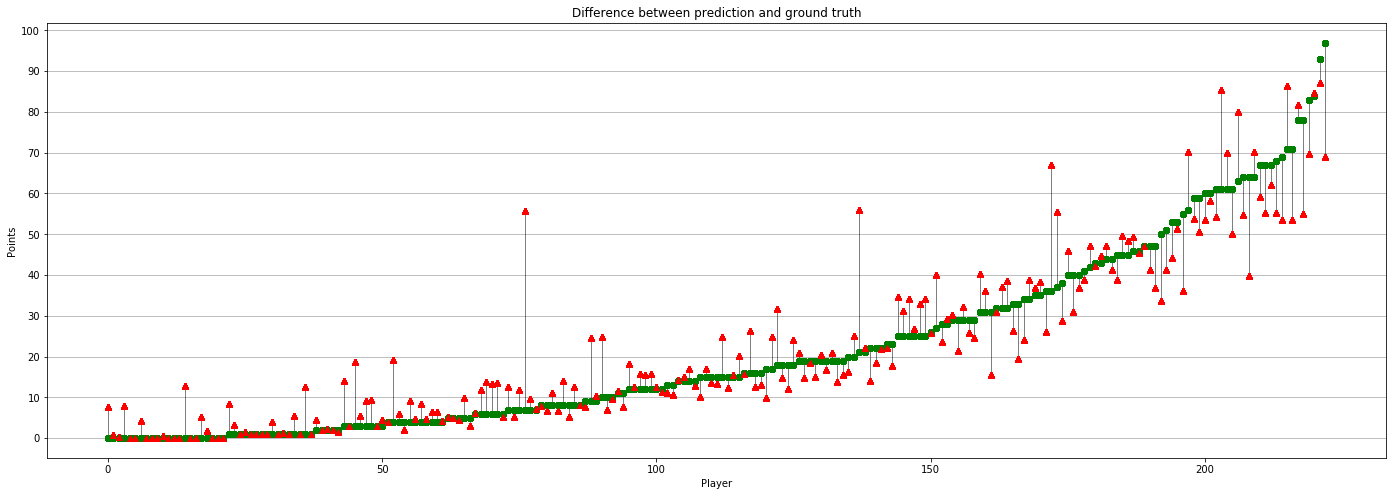

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(best_predictions)):
    ax.plot([i,i],[best_predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(best_predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.title('Difference between prediction and ground truth')

plt.show()

---
# Train/Test Model - LR

In [ ]:
%%time
lr = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=5000)

# Train the model on training data
lr.fit(train_features, train_labels);

CPU times: user 32.4 s, sys: 1.02 s, total: 33.4 s
Wall time: 17.6 s


/home/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
# Use the forest's predict method on the test data
predictions = lr.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

Mean Absolute Error: 7.67 points.
Mean Squared Error: 163.74 points.
Explained Variance Score: 0.67
R2 Score: 0.67


---
# Train/Test Model - XGBoost

In [ ]:
%%time
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, random_state=42)

# Train the model on training data
xgb.fit(train_features, train_labels);

CPU times: user 453 ms, sys: 31.2 ms, total: 484 ms
Wall time: 509 ms


In [ ]:
# Use the forest's predict method on the test data
predictions = xgb.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

Mean Absolute Error: 5.03 points.
Mean Squared Error: 58.92 points.
Explained Variance Score: 0.88
R2 Score: 0.88


In [ ]:
def objective(space):

    clf = xgboost.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = space['max_depth'],
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:linear'
                           )
    
    clf.fit(train_features,
            train_labels,
            eval_metric = 'mae')

    pred = clf.predict(test_features)
    
#   mae = mean_absolute_error(np.exp(y_valid), np.exp(pred))
    mae = mean_absolute_error((test_labels), (pred))

    return {'loss':mae, 'status': STATUS_OK }

In [ ]:
%time
space ={
        'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 20, 1),
        'subsample': hp.uniform ('subsample', 0.8, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(1000, 10000, 100, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

# space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
#         'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#         # A problem with max_depth casted to float instead of int with
#         # the hp.quniform method.
#         'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#         'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
#         # Increase this number if you have more cores. Otherwise, remove it and it will default 
#         # to the maxium number. 
#         'nthread': 4,
#         'booster': 'gbtree',
#         'tree_method': 'exact',
#         'silent': 1,
#         'seed': random_state
#     }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # change
            trials=trials)

print(best)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
